### General

```mermaid
graph LR;
    A[Capture Img] --> |origin img| B[Book Detection] --> |Bookspine Segments| C[Text Localization] --> |Text regions crops| D[OCR];

#### Book Detection
```mermaid
graph LR;
    A[input] --> |grayscale img| B[Img Processing - Done] --> |Book Regions| C[Unknown] --> |Bookspines| D[output]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import PIL

In [639]:
samples_path = [os.path.join('.\\Samples', f) for f in os.listdir('./Samples') if f.endswith('.jpg')]

In [640]:
samples = [cv2.imread(f) for f in samples_path]

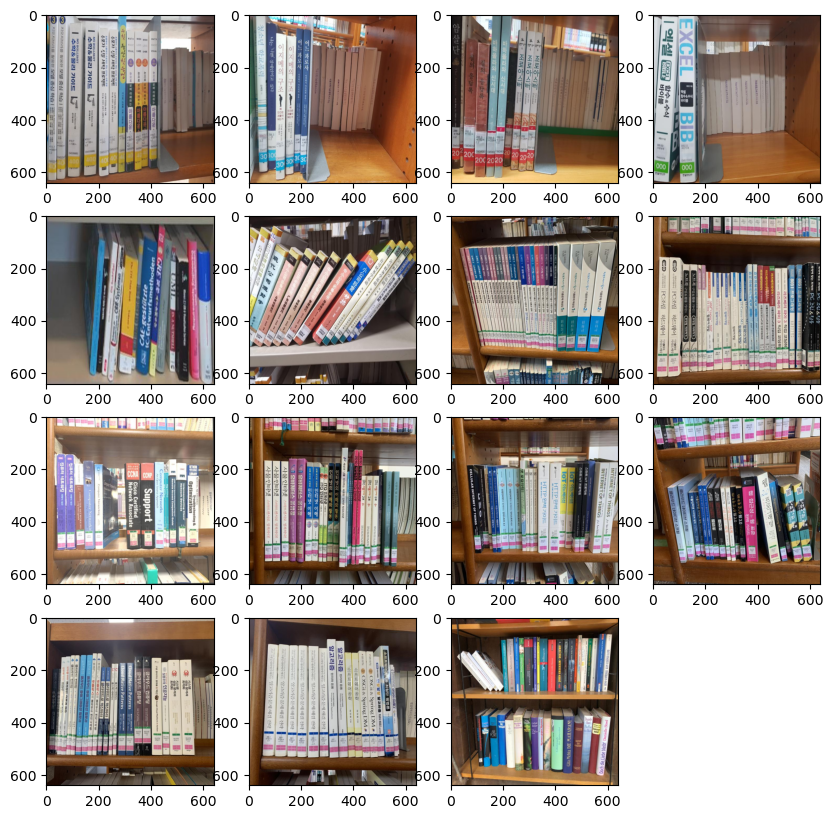

In [641]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(samples):
    plt.subplot(len(samples)//4 + 1, 4, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Text(0.5, 1.0, 'Bounding Box on Original Image')

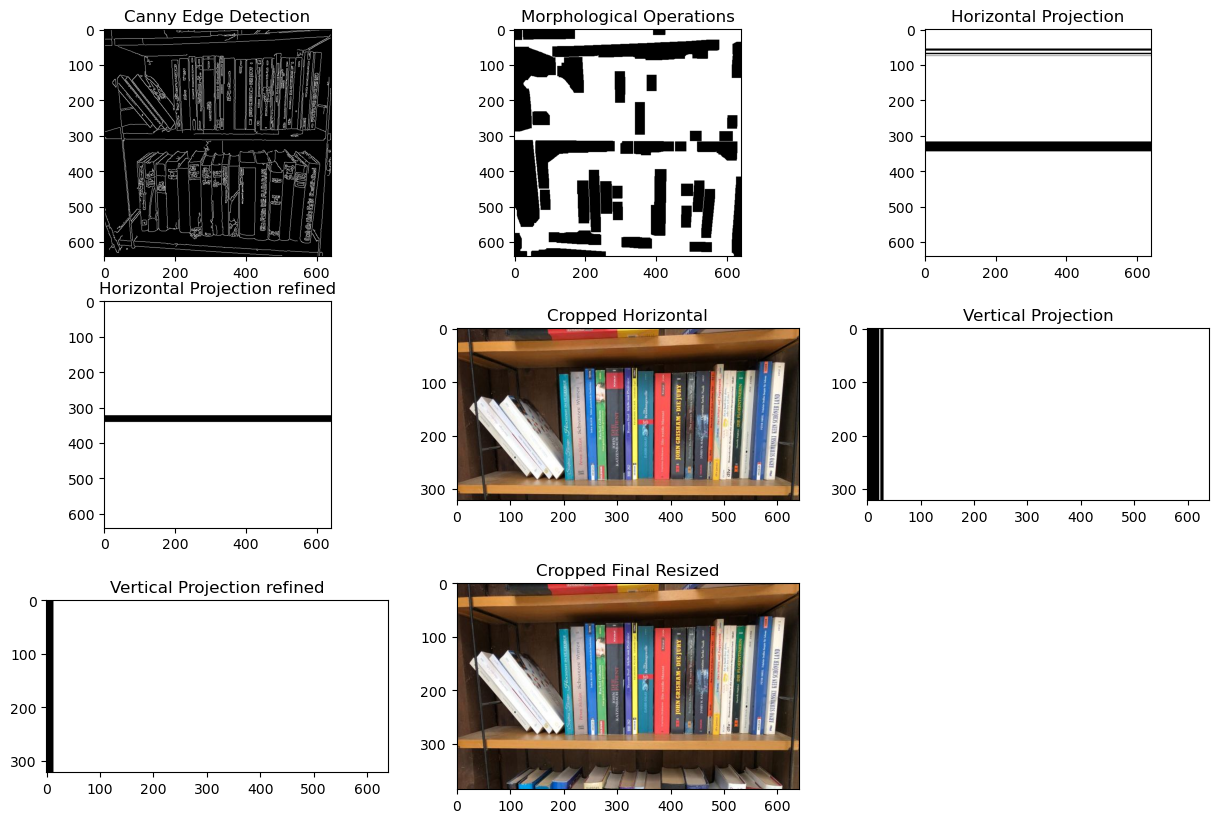

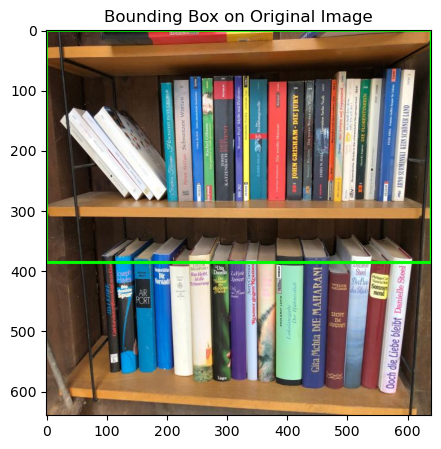

In [915]:
# Horizontal cut
img = samples[14].copy()
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
gray = cv2.GaussianBlur(gray, (3, 3), 0)

# Apply Canny edge detection
edges = cv2.Canny(gray, 0, 200)

# Morphological operations
kernel_close = np.ones((10, 10), np.uint8)
morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_close, iterations=3)

hoz = morph.copy()
T = hoz.shape[1] * 0.15
for i in range(hoz.shape[0]):
    if np.sum((hoz[i, :] == 255)) > T:
        hoz[i, :] = 255
    else:
        hoz[i, :] = 0
# Refine the horizontal projection image
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 10))
hoz_refined = cv2.dilate(hoz, kernel_dilate, iterations=1)

# Find contours in the binary image
contours_hoz, _ = cv2.findContours(hoz_refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour by area
largest_contour_hoz = max(contours_hoz, key=cv2.contourArea)

# Get the bounding box of the largest contour
x, y_saved, w, h_saved = cv2.boundingRect(largest_contour_hoz)

# Crop the largest white part from the binary image
cropped_image_gray_hoz = gray[y_saved:y_saved+h_saved, x:x+w].copy()
cropped_image_color_hoz = img[y_saved:y_saved+h_saved, x:x+w].copy()


ver = morph[y_saved:y_saved+h_saved, x:x+w].copy()
T = ver.shape[0] * 0.2
for i in range(ver.shape[1]):
    if np.sum((ver[:, i] == 255)) > T:
        ver[:, i] = 255
    else:
        ver[:, i] = 0
# Refine the vertical projection image
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 3))
ver_refined = cv2.dilate(ver, kernel_dilate, iterations=1)

# Find contours in the vertical projection image
contours_ver, _ = cv2.findContours(ver_refined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour by area
largest_contour_ver = max(contours_ver, key=cv2.contourArea)

# Get the bounding box of the largest contour
x_saved, y, w_saved, h = cv2.boundingRect(largest_contour_ver)

# Refine box to include a little surrounding area
x_saved = max(x_saved - int(img.shape[1] * 0.05), 0)
y_saved = max(y_saved - int(img.shape[0] * 0.05), 0)
w_saved = min(w_saved + int(img.shape[1] * 0.1), img.shape[1] - x_saved)
h_saved = min(h_saved + int(img.shape[0] * 0.1), img.shape[0] - y_saved)

# Crop the largest white part from the vertical projection image
cropped_image_gray_final = gray[y_saved:y_saved+h_saved, x_saved:x_saved+w_saved]
cropped_image_color_final = img[y_saved:y_saved+h_saved, x_saved:x_saved+w_saved, :]

# Plot all images together in a subplot
plt.figure(figsize=(15, 10))

plt.subplot(3, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')

plt.subplot(3, 3, 2)
plt.imshow(morph, cmap='gray')
plt.title('Morphological Operations')

plt.subplot(3, 3, 3)
plt.imshow(hoz, cmap='gray')
plt.title('Horizontal Projection')

plt.subplot(3, 3, 4)
plt.imshow(hoz_refined, cmap='gray')
plt.title('Horizontal Projection refined')

# Plot the cropped image
plt.subplot(3, 3, 5)
plt.imshow(cv2.cvtColor(cropped_image_color_hoz, cv2.COLOR_BGR2RGB))
plt.title('Cropped Horizontal')

plt.subplot(3, 3, 6)
plt.imshow(ver, cmap='gray')
plt.title('Vertical Projection')

plt.subplot(3, 3, 7)
plt.imshow(ver_refined, cmap='gray')
plt.title('Vertical Projection refined')

plt.subplot(3, 3, 8)
plt.imshow(cv2.cvtColor(cropped_image_color_final, cv2.COLOR_BGR2RGB))
plt.title('Cropped Final Resized')

# Draw the bounding box on the original image
img_with_box = img.copy()
cv2.rectangle(img_with_box, (x_saved, y_saved), (x_saved + w_saved, y_saved + h_saved), (0, 255, 0), 4)

# Plot the image with the bounding box
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
plt.title('Bounding Box on Original Image')

In [812]:
def preprocess_image(image):
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Use adaptive histogram equalization to enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    return enhanced

def detect_edges(image):
    # Apply Canny edge detection
    edges = cv2.Canny(image, threshold1=100, threshold2=300)
    return edges

def detect_lines(edges):
    # Apply Hough Line Transform
    lines = cv2.HoughLines(edges, rho=1, theta=np.pi /180, threshold=120)
    return lines

def filter_vertical_lines(lines, angle_tolerance=30):
    """
    Filters lines to only include those near vertical (aligned with the y-axis).
    :param lines: List of (rho, theta) from Hough Transform.
    :param angle_tolerance: Maximum deviation from 90° or 270° (in degrees).
    :return: Filtered list of (rho, theta) lines.
    """
    filtered_lines = []
    for rho, theta in lines[:, 0]:
        # Convert theta to degrees for readability
        angle = np.degrees(theta)
        
        # Check if the line is near vertical (0° or 360°)
        if abs(angle - 0) <= angle_tolerance or abs(angle - 360) <= angle_tolerance:
            filtered_lines.append((rho, theta))
    return filtered_lines


def draw_lines(image, lines):
    output = image.copy()
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)
        cv2.line(output, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return output

def segment_books(image, lines):
    # Sort lines by rho (distance from origin)
    lines = sorted(lines, key=lambda x: x[0])
    spine_regions = []
    for i in range(len(lines) - 1):
        rho1, theta1 = lines[i]
        rho2, theta2 = lines[i + 1]
        x1, x2 = int(rho1), int(rho2)
        # Extract the region between two consecutive lines
        spine = image[:, x1:x2]
        spine_regions.append(spine)
    return spine_regions



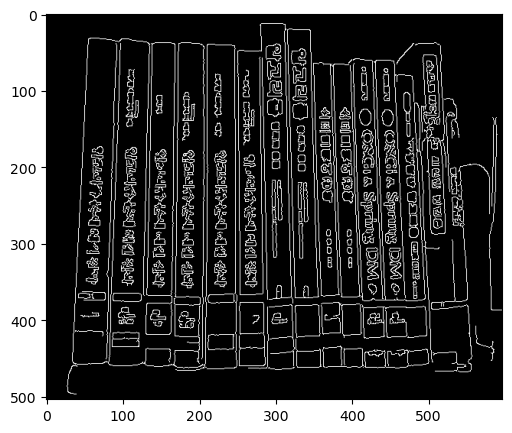

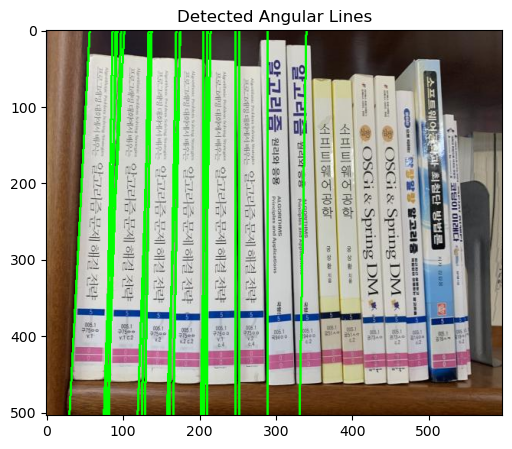

In [870]:
# Load and preprocess the image
preprocessed_image = preprocess_image(cropped_image_gray_final)

# Detect edges
edges = detect_edges(preprocessed_image)
plt.figure(figsize=(10, 5))
plt.imshow(edges, cmap='gray')

# Detect lines using Hough Transform
lines = detect_lines(edges)

# Filter lines by angular orientation
angular_lines = filter_vertical_lines(lines)

# Draw the detected lines on the original image
line_image = draw_lines(cropped_image_color_final, angular_lines)

# Display the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Angular Lines")
plt.show()

